# PCA Analysis for Yield Strength Prediction

## Why PCA for Yield Strength?

**Problem**: The dataset contains 50+ features including chemical composition, welding parameters, and process conditions. Many of these features are highly correlated.

**Why PCA is necessary**:

1. **Multicollinearity**: Chemical elements like C, Mn, Si are often correlated due to steel composition requirements. This creates redundant information and unstable model coefficients.

2. **Dimensionality Curse**: With 780 samples and 50+ features, the ratio is only 15:1. PCA reduces features while retaining 90-95% of variance, improving model generalization.

3. **Noise Reduction**: Minor variations in measurements contribute little to prediction but add noise. PCA captures systematic variation while filtering noise.

4. **Computational Efficiency**: Training models on 15-20 principal components is faster than 50+ original features, especially for GridSearchCV with cross-validation.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [ ]:
os.makedirs('pca_model', exist_ok=True)
os.makedirs('data', exist_ok=True)
os.makedirs('figures', exist_ok=True)

In [ ]:
df = pd.read_csv('../../welddatabase/welddb_pca.csv')
print(f"Prepared dataset shape: {df.shape}")


Prepared dataset shape: (1652, 52)


In [6]:
df_ys = df[df['Yield_Strength_MPa'].notna()].copy()
print(f"Samples with Yield Strength: {len(df_ys)}")
print(f"Percentage retained: {len(df_ys)/len(df)*100:.1f}%")

Samples with Yield Strength: 780
Percentage retained: 47.2%


In [7]:
target_columns = ['Yield_Strength_MPa', 'UTS_MPa', 'Elongation_%', 
                  'Reduction_Area_%', 'Charpy_Temp_C', 'Charpy_Energy_J',
                  'Hardness_kg_mm2', 'FATT_50%', 'Primary_Ferrite_%',
                  'Ferrite_2nd_Phase_%', 'Acicular_Ferrite_%', 'Martensite_%',
                  'Ferrite_Carbide_%']

df_ys = df[df['Yield_Strength_MPa'].notna()].copy()
y = df_ys['Yield_Strength_MPa'].copy()
X = df_ys.drop(columns=target_columns)

print(f"Samples with Yield Strength: {len(df_ys)}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Samples with Yield Strength: 780
Features shape: (780, 39)
Target shape: (780,)


## Feature Imputation

**Why KNN Imputer?**

KNN Imputer is robust to different missing data mechanisms (MCAR, MAR, MNAR) because:

1. **Non-parametric approach**: Makes no assumptions about data distribution or missing mechanism
2. **Local similarity**: Imputes based on similar samples, preserving relationships between features
3. **Handles correlations**: Leverages multivariate structure naturally present in welding data
4. **Distance-based weighting**: Closer neighbors contribute more, reducing noise from dissimilar samples

In [8]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, weights='distance')
X_imputed = imputer.fit_transform(X)

print(f"Missing values after imputation: {pd.DataFrame(X_imputed).isnull().sum().sum()}")
print(f"Shape: {X_imputed.shape}")

Missing values after imputation: 0
Shape: (780, 39)


## PCA Variance Analysis

Data is already standardized, ready for PCA application.

In [9]:
pca_full = PCA()
pca_full.fit(X_imputed)

variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_ratio)

n_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Components for 90% variance: {n_90}")
print(f"Components for 95% variance: {n_95}")

Components for 90% variance: 17
Components for 95% variance: 21


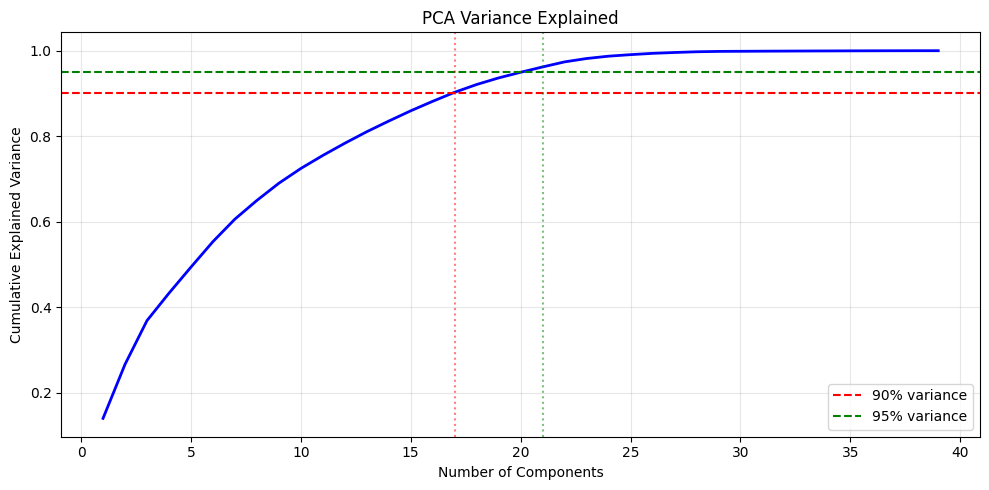

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'b-', linewidth=2)
ax.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
ax.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
ax.axvline(x=n_90, color='r', linestyle=':', alpha=0.5)
ax.axvline(x=n_95, color='g', linestyle=':', alpha=0.5)

ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Explained Variance')
ax.set_title('PCA Variance Explained')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/pca_variance.png', dpi=300, bbox_inches='tight')
plt.show()

## Apply PCA with 90% Variance

In [11]:
pca = PCA(n_components=0.90, random_state=42)
X_pca = pca.fit_transform(X_imputed)

print(f"Original features: {X_imputed.shape[1]}")
print(f"PCA components: {X_pca.shape[1]}")
print(f"Variance retained: {pca.explained_variance_ratio_.sum():.4f}")

Original features: 39
PCA components: 17
Variance retained: 0.9029


In [27]:
pc_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pc_columns)
df_pca['Yield_Strength_MPa'] = y.values

df_pca.to_csv('data/welddb_pca_ys.csv', index=False)
print(f"Shape: {df_pca.shape}")

Shape: (780, 18)


## Component Interpretation

In [13]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=pc_columns,
    index=X.columns
)

print("Top 5 contributors to PC1:")
print(loadings['PC1'].abs().sort_values(ascending=False).head())

Top 5 contributors to PC1:
Heat_Input_J_mm     0.371475
Tungsten_%          0.327349
Cobalt_%            0.302450
Interpass_Temp_C    0.285175
PWHT_Temp_C         0.256490
Name: PC1, dtype: float64


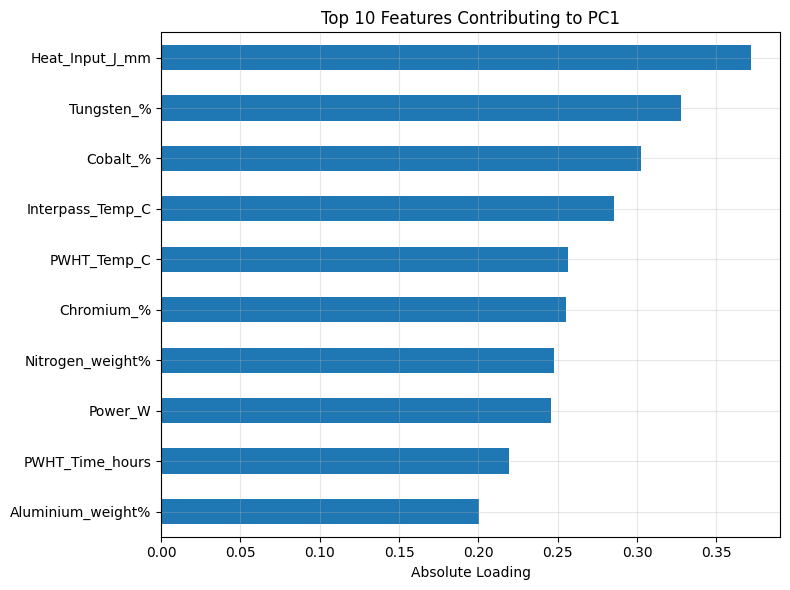

In [14]:
top_features_pc1 = loadings['PC1'].abs().nlargest(10)

fig, ax = plt.subplots(figsize=(8, 6))
top_features_pc1.sort_values().plot(kind='barh', ax=ax)
ax.set_xlabel('Absolute Loading')
ax.set_title('Top 10 Features Contributing to PC1')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/pc1_loadings.png', dpi=300, bbox_inches='tight')
plt.show()

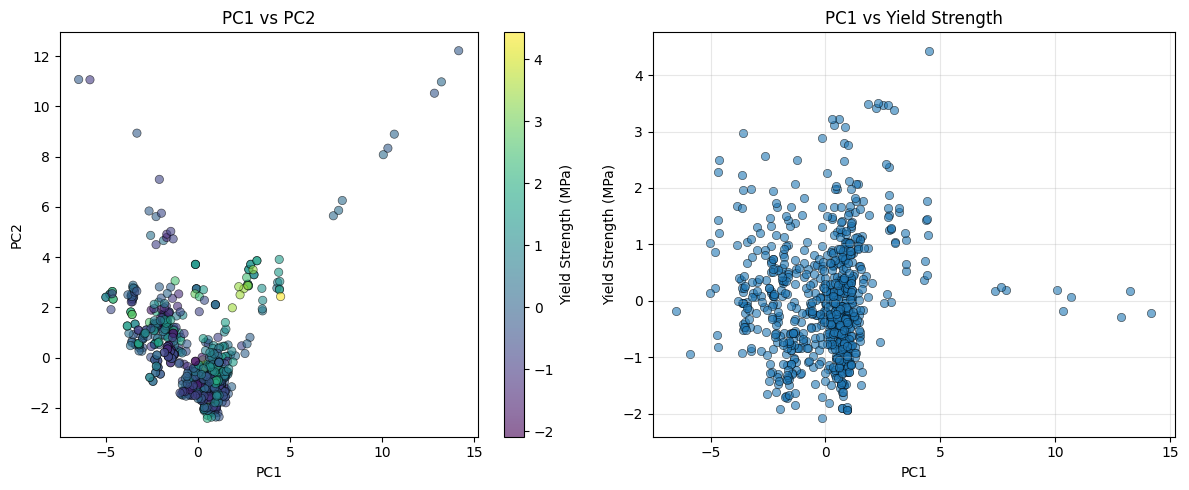

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Yield_Strength_MPa'], 
                cmap='viridis', alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('PC1 vs PC2')
cbar1 = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar1.set_label('Yield Strength (MPa)')

axes[1].scatter(df_pca['PC1'], df_pca['Yield_Strength_MPa'], alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('Yield Strength (MPa)')
axes[1].set_title('PC1 vs Yield Strength')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
correlation_with_target = df_pca.drop('Yield_Strength_MPa', axis=1).corrwith(df_pca['Yield_Strength_MPa'])
correlation_with_target = correlation_with_target.abs().sort_values(ascending=False)

print("Top 5 PCs correlated with Yield Strength:")
print(correlation_with_target.head())

Top 5 PCs correlated with Yield Strength:
PC10    0.365767
PC11    0.229139
PC2     0.204174
PC4     0.191530
PC16    0.181129
dtype: float64


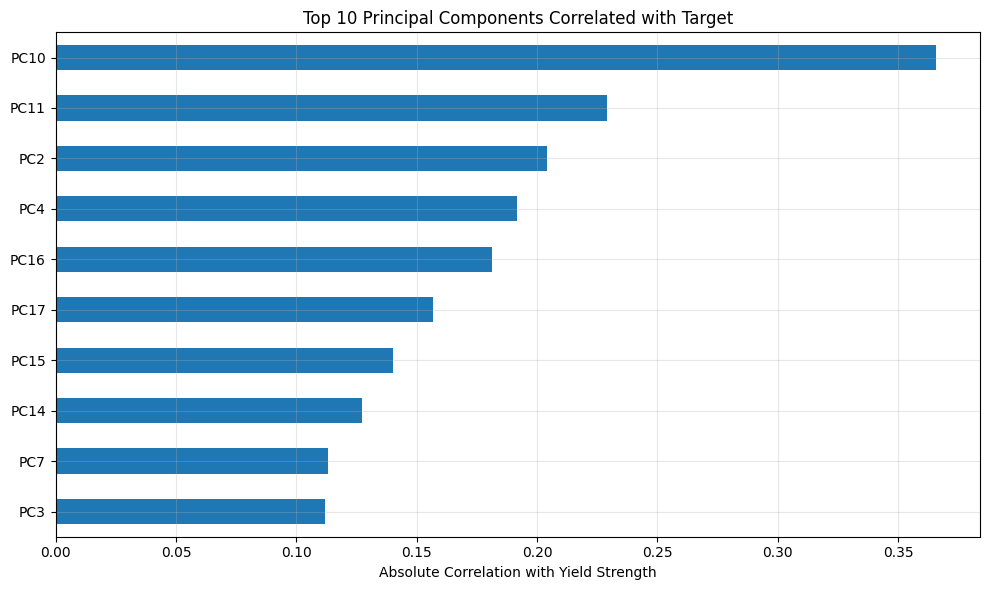

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
correlation_with_target.head(10).sort_values().plot(kind='barh', ax=ax)
ax.set_xlabel('Absolute Correlation with Yield Strength')
ax.set_title('Top 10 Principal Components Correlated with Target')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/pc_target_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# Reconstruct original features
X_reconstructed = pca.inverse_transform(X_pca)

# Calculate reconstruction error
reconstruction_error = np.mean((X_imputed - X_reconstructed) ** 2, axis=0)
reconstruction_df = pd.DataFrame({
    'Feature': X.columns,
    'Reconstruction_Error': reconstruction_error
}).sort_values('Reconstruction_Error', ascending=False)

print("Top 10 features with highest reconstruction error:")
print(reconstruction_df.head(10))

print(f"\nMean reconstruction error: {reconstruction_error.mean():.6f}")
print(f"Max reconstruction error: {reconstruction_error.max():.6f}")

Top 10 features with highest reconstruction error:
              Feature  Reconstruction_Error
17    Niobium_weight%              0.220310
22        PWHT_Temp_C              0.217357
15  Aluminium_weight%              0.198879
0            Carbon_%              0.193659
16      Boron_weight%              0.185264
14   Nitrogen_weight%              0.169775
7        Molybdenum_%              0.167571
3           Sulphur_%              0.162714
4        Phosphorus_%              0.131556
1           Silicon_%              0.112067

Mean reconstruction error: 0.072620
Max reconstruction error: 0.220310


### Reconstruction Error Analysis

How well can we reconstruct original features from PCA components?

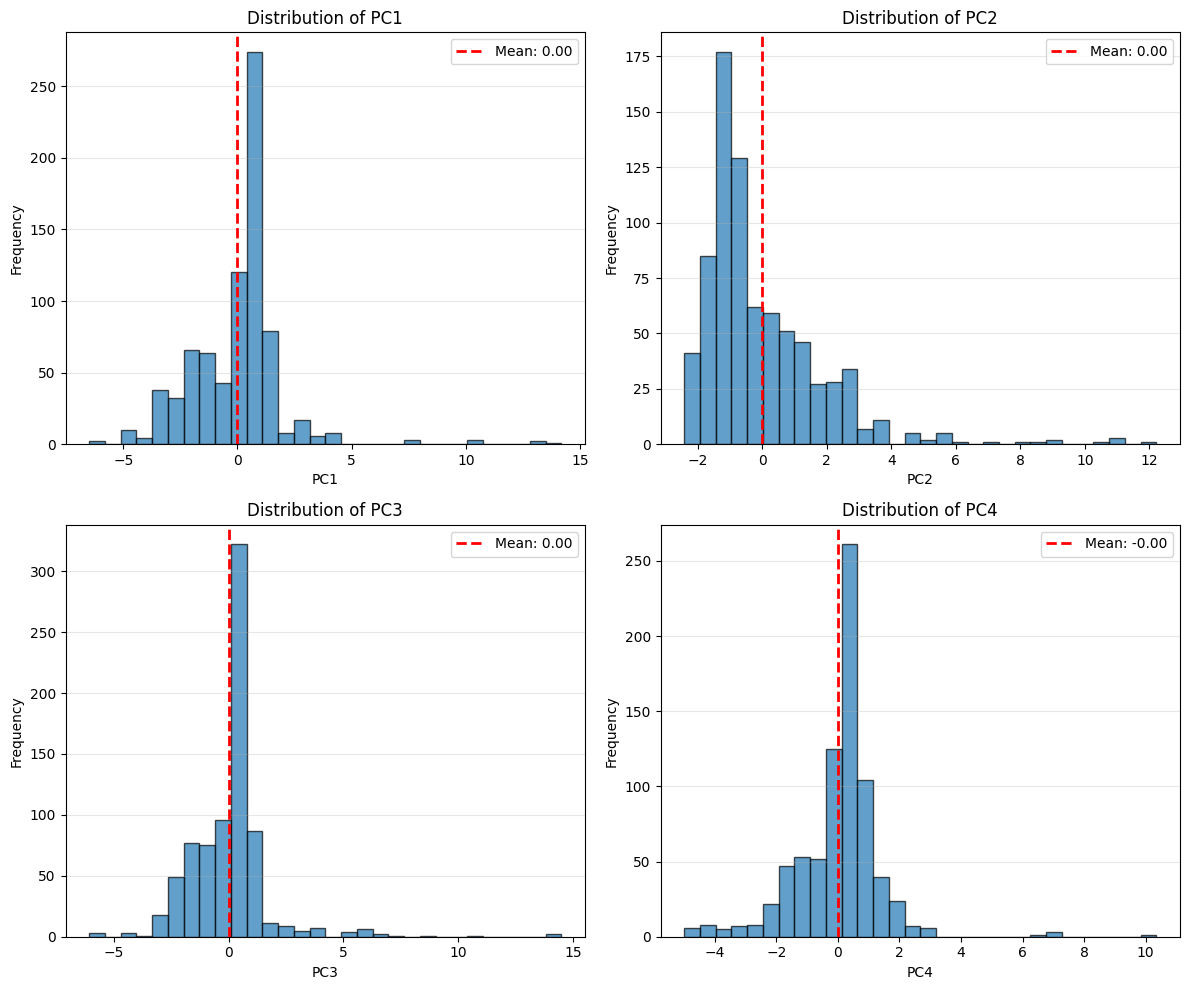

In [19]:
# Distribution plots for first 4 PCs
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i in range(min(4, len(pc_columns))):
    axes[i].hist(df_pca[f'PC{i+1}'], bins=30, edgecolor='k', alpha=0.7)
    axes[i].axvline(df_pca[f'PC{i+1}'].mean(), color='r', linestyle='--', 
                    linewidth=2, label=f'Mean: {df_pca[f"PC{i+1}"].mean():.2f}')
    axes[i].set_xlabel(f'PC{i+1}')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Distribution of PC{i+1}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/pc_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

### Statistical Summary of PCA Components

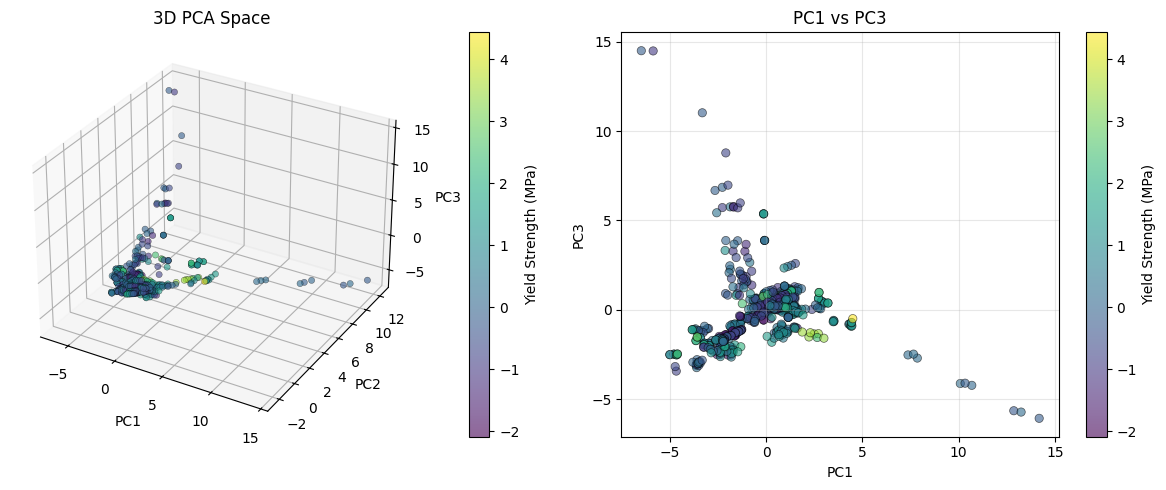

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 5))

# 3D scatter plot
ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], 
                      c=df_pca['Yield_Strength_MPa'], cmap='viridis', 
                      alpha=0.6, edgecolors='k', linewidth=0.3)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('3D PCA Space')
cbar = plt.colorbar(scatter, ax=ax1, pad=0.1)
cbar.set_label('Yield Strength (MPa)')

# Pair plot PC1 vs PC3
ax2 = fig.add_subplot(122)
scatter2 = ax2.scatter(df_pca['PC1'], df_pca['PC3'], 
                       c=df_pca['Yield_Strength_MPa'], cmap='viridis',
                       alpha=0.6, edgecolors='k', linewidth=0.5)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC3')
ax2.set_title('PC1 vs PC3')
ax2.grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Yield Strength (MPa)')

plt.tight_layout()
plt.savefig('figures/pca_3d_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

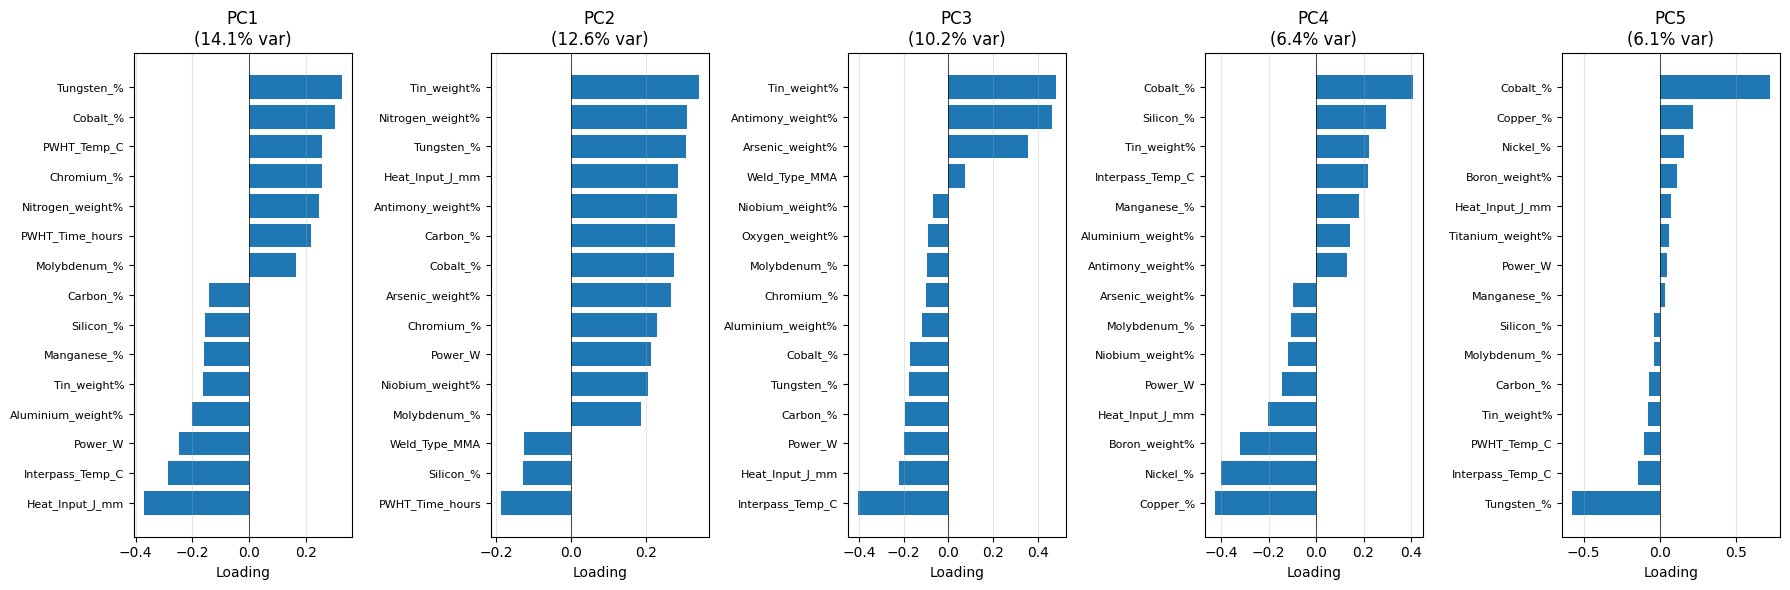

In [23]:
# Show top contributing features for first 5 PCs
n_components_to_show = min(5, len(pc_columns))
n_features_to_show = 15

fig, axes = plt.subplots(1, n_components_to_show, figsize=(18, 6))

for i in range(n_components_to_show):
    top_features = loadings[f'PC{i+1}'].abs().nlargest(n_features_to_show)
    top_features_sorted = loadings.loc[top_features.index, f'PC{i+1}'].sort_values()
    
    axes[i].barh(range(len(top_features_sorted)), top_features_sorted.values)
    axes[i].set_yticks(range(len(top_features_sorted)))
    axes[i].set_yticklabels(top_features_sorted.index, fontsize=8)
    axes[i].set_xlabel('Loading')
    axes[i].set_title(f'PC{i+1}\n({pca.explained_variance_ratio_[i]:.1%} var)')
    axes[i].axvline(x=0, color='k', linestyle='-', linewidth=0.5)
    axes[i].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('figures/pc_feature_loadings.png', dpi=300, bbox_inches='tight')
plt.show()

### Feature Contributions Heatmap

Visualize how original features contribute to the first principal components.

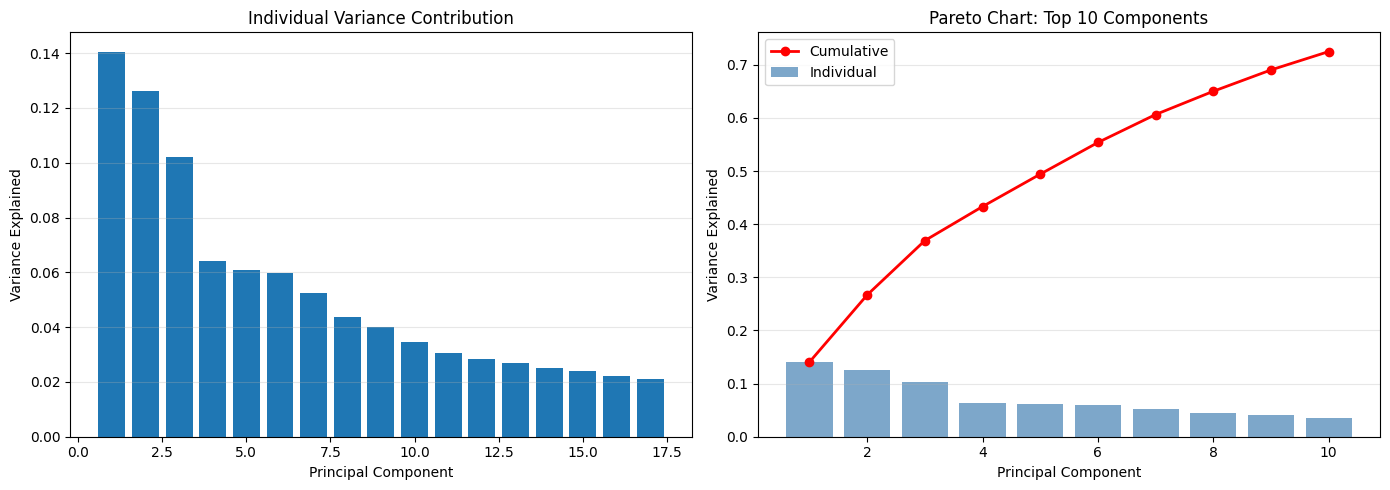

In [24]:
# Visualize individual variance contribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of variance
axes[0].bar(range(1, len(pc_columns) + 1), pca.explained_variance_ratio_)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')
axes[0].set_title('Individual Variance Contribution')
axes[0].grid(True, alpha=0.3, axis='y')

# Pareto chart (top 10)
top_10_var = pca.explained_variance_ratio_[:10]
top_10_cum = np.cumsum(top_10_var)
x_pos = np.arange(1, 11)

axes[1].bar(x_pos, top_10_var, color='steelblue', alpha=0.7, label='Individual')
axes[1].plot(x_pos, top_10_cum, 'ro-', linewidth=2, label='Cumulative')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Variance Explained')
axes[1].set_title('Pareto Chart: Top 10 Components')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/variance_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:

variance_df = pd.DataFrame({
    'Component': pc_columns,
    'Variance_Explained': pca.explained_variance_ratio_,
    'Cumulative_Variance': np.cumsum(pca.explained_variance_ratio_)
})

print("Variance contribution by component:")
print(variance_df.head(10))
print(f"\nFirst 5 components capture: {variance_df['Cumulative_Variance'].iloc[4]:.2%} of variance")

Variance contribution by component:
  Component  Variance_Explained  Cumulative_Variance
0       PC1            0.140567             0.140567
1       PC2            0.126248             0.266815
2       PC3            0.102275             0.369090
3       PC4            0.064030             0.433121
4       PC5            0.060964             0.494085
5       PC6            0.059597             0.553683
6       PC7            0.052628             0.606310
7       PC8            0.043726             0.650037
8       PC9            0.040164             0.690201
9      PC10            0.034527             0.724727

First 5 components capture: 49.41% of variance


## Save Models

In [26]:
joblib.dump(pca, 'pca_model/pca_model.pkl')
joblib.dump(imputer, 'pca_model/imputer.pkl')

print("Saved PCA pipeline:")
print("- pca_model/pca_model.pkl")
print("- pca_model/imputer.pkl")

Saved PCA pipeline:
- pca_model/pca_model.pkl
- pca_model/imputer.pkl
